In [ ]:
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import regularizers
!pip install keras_preprocessing
import os
from keras.utils import to_categorical
from keras_preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
!pip install wandb
import wandb
from wandb.keras import WandbCallback

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# GPU

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Dataset

In [ ]:
(x, y), (test_X, test_y) = mnist.load_data()
train_X, val_X, train_y, val_y = train_test_split(x, y, test_size=0.16666666666666666667, random_state=42, stratify=y)
print('X_train: ' + str(train_X.shape))
print('Y_train: ' + str(train_y.shape))
print('X_val: ' + str(val_X.shape))
print('Y_val: ' + str(val_y.shape))
print('X_test:  '  + str(test_X.shape))
print('Y_test:  '  + str(test_y.shape))

X_train: (50000, 28, 28)
Y_train: (50000,)
X_val: (10000, 28, 28)
Y_val: (10000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)


# Training

In [ ]:
IMG_PX_SIZE = 28
train_X = train_X.reshape(train_X.shape[0], IMG_PX_SIZE, IMG_PX_SIZE, 1).astype('float32')
val_X = val_X.reshape(val_X.shape[0], IMG_PX_SIZE, IMG_PX_SIZE, 1).astype('float32')
test_X = test_X.reshape(test_X.shape[0], IMG_PX_SIZE, IMG_PX_SIZE, 1).astype('float32')
train_X /= 255
val_X /= 255
test_X /= 255
train_y = to_categorical(train_y, 10)
val_y = to_categorical(val_y, 10)
test_y = to_categorical(test_y, 10)

In [ ]:
wandb.init(project="Nsiete_zadanie1_tensorflow")

accuracy,▁▅▆▇▇▇▇▇▇████████████████
epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▄▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_acc,▁
test_loss,▁
val_accuracy,▁▃▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇████████
val_loss,█▆▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
accuracy,0.97258
best_epoch,23
best_val_loss,0.08832
epoch,24


In [ ]:
checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

# changelog - hyperparametre, odstranovanie overfitu
BATCH = 50
EPOCHS = 25
OPTIMIZER_LEARNING_RATE = 0.0001
REGULARIZER_LEARNING_RATE = 0.0001
IMG_PX_SIZE = 28

wandb.config.batch_size = BATCH
wandb.config.epochs = EPOCHS
wandb.config.optimizer_learning_rate = OPTIMIZER_LEARNING_RATE
wandb.config.regularizer_learning_rate = REGULARIZER_LEARNING_RATE

# training_datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)
# changelog - augmentacie
training_datagen = ImageDataGenerator(rotation_range=20, fill_mode='nearest', width_shift_range=0.1, height_shift_range=0.1)
train_generator = training_datagen.flow(train_X,train_y)

validation_datagen = ImageDataGenerator()
validation_generator = validation_datagen.flow(val_X,val_y)

with tf.device('/gpu:0'):
  model = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_regularizer=regularizers.l2(REGULARIZER_LEARNING_RATE), input_shape=(IMG_PX_SIZE, IMG_PX_SIZE, 1)),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_regularizer=regularizers.l2(REGULARIZER_LEARNING_RATE)),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_regularizer=regularizers.l2(REGULARIZER_LEARNING_RATE)),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(REGULARIZER_LEARNING_RATE)),
      tf.keras.layers.Dense(10, activation='softmax')
  ])

  model.summary()
#   optimizer = tf.keras.optimizers.RMSprop(learning_rate=OPTIMIZER_LEARNING_RATE)
  optimizer = tf.keras.optimizers.Adam(learning_rate=OPTIMIZER_LEARNING_RATE)

  model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
  history = model.fit(train_generator, epochs=EPOCHS, batch_size=BATCH, validation_data = validation_generator, shuffle=True, verbose = 1, callbacks=[model_checkpoint_callback, WandbCallback()])
  model.load_weights(checkpoint_filepath)
  model.save("/mnist_classification_model.h5")

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 26, 26, 64)        640       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 13, 13, 64)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 11, 11, 64)        36928     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 3, 3, 128)         73856     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 1, 1, 128)       

wandb: Adding directory to artifact (/content/wandb/run-20230328_202323-apsnuqu6/files/model-best)... Done. 0.0s


1563/1563 [==============================] - 38s 23ms/step - loss: 0.9730 - accuracy: 0.6979 - val_loss: 0.2814 - val_accuracy: 0.9294
Epoch 2/25
1563/1563 [==============================] - ETA: 0s - loss: 0.4631 - accuracy: 0.8658

wandb: Adding directory to artifact (/content/wandb/run-20230328_202323-apsnuqu6/files/model-best)... Done. 0.0s


1563/1563 [==============================] - 22s 14ms/step - loss: 0.4631 - accuracy: 0.8658 - val_loss: 0.1997 - val_accuracy: 0.9502
Epoch 3/25
1561/1563 [============================>.] - ETA: 0s - loss: 0.3618 - accuracy: 0.8997

wandb: Adding directory to artifact (/content/wandb/run-20230328_202323-apsnuqu6/files/model-best)... Done. 0.0s


1563/1563 [==============================] - 22s 14ms/step - loss: 0.3616 - accuracy: 0.8997 - val_loss: 0.1811 - val_accuracy: 0.9565
Epoch 4/25
1563/1563 [==============================] - ETA: 0s - loss: 0.3170 - accuracy: 0.9109

wandb: Adding directory to artifact (/content/wandb/run-20230328_202323-apsnuqu6/files/model-best)... Done. 0.0s


1563/1563 [==============================] - 23s 15ms/step - loss: 0.3170 - accuracy: 0.9109 - val_loss: 0.1595 - val_accuracy: 0.9619
Epoch 5/25
1562/1563 [============================>.] - ETA: 0s - loss: 0.2818 - accuracy: 0.9240

wandb: Adding directory to artifact (/content/wandb/run-20230328_202323-apsnuqu6/files/model-best)... Done. 0.0s


1563/1563 [==============================] - 24s 15ms/step - loss: 0.2819 - accuracy: 0.9240 - val_loss: 0.1520 - val_accuracy: 0.9640
Epoch 6/25
1562/1563 [============================>.] - ETA: 0s - loss: 0.2590 - accuracy: 0.9309

wandb: Adding directory to artifact (/content/wandb/run-20230328_202323-apsnuqu6/files/model-best)... Done. 0.0s


1563/1563 [==============================] - 24s 15ms/step - loss: 0.2591 - accuracy: 0.9309 - val_loss: 0.1400 - val_accuracy: 0.9684
Epoch 7/25
1561/1563 [============================>.] - ETA: 0s - loss: 0.2431 - accuracy: 0.9364

wandb: Adding directory to artifact (/content/wandb/run-20230328_202323-apsnuqu6/files/model-best)... Done. 0.0s


1563/1563 [==============================] - 23s 15ms/step - loss: 0.2431 - accuracy: 0.9364 - val_loss: 0.1295 - val_accuracy: 0.9725
Epoch 8/25
1563/1563 [==============================] - 22s 14ms/step - loss: 0.2306 - accuracy: 0.9404 - val_loss: 0.1349 - val_accuracy: 0.9701
Epoch 9/25
1560/1563 [============================>.] - ETA: 0s - loss: 0.2158 - accuracy: 0.9444

wandb: Adding directory to artifact (/content/wandb/run-20230328_202323-apsnuqu6/files/model-best)... Done. 0.0s


1563/1563 [==============================] - 23s 14ms/step - loss: 0.2157 - accuracy: 0.9444 - val_loss: 0.1239 - val_accuracy: 0.9731
Epoch 10/25
1563/1563 [==============================] - 20s 13ms/step - loss: 0.2041 - accuracy: 0.9488 - val_loss: 0.1282 - val_accuracy: 0.9710
Epoch 11/25
1560/1563 [============================>.] - ETA: 0s - loss: 0.1948 - accuracy: 0.9518

wandb: Adding directory to artifact (/content/wandb/run-20230328_202323-apsnuqu6/files/model-best)... Done. 0.0s


1563/1563 [==============================] - 23s 15ms/step - loss: 0.1948 - accuracy: 0.9518 - val_loss: 0.1238 - val_accuracy: 0.9732
Epoch 12/25
1559/1563 [============================>.] - ETA: 0s - loss: 0.1899 - accuracy: 0.9529

wandb: Adding directory to artifact (/content/wandb/run-20230328_202323-apsnuqu6/files/model-best)... Done. 0.0s


1563/1563 [==============================] - 22s 14ms/step - loss: 0.1899 - accuracy: 0.9529 - val_loss: 0.1119 - val_accuracy: 0.9775
Epoch 13/25
1563/1563 [==============================] - ETA: 0s - loss: 0.1838 - accuracy: 0.9551

wandb: Adding directory to artifact (/content/wandb/run-20230328_202323-apsnuqu6/files/model-best)... Done. 0.0s


1563/1563 [==============================] - 23s 15ms/step - loss: 0.1838 - accuracy: 0.9551 - val_loss: 0.1110 - val_accuracy: 0.9777
Epoch 14/25
1563/1563 [==============================] - 22s 14ms/step - loss: 0.1786 - accuracy: 0.9561 - val_loss: 0.1157 - val_accuracy: 0.9769
Epoch 15/25
1563/1563 [==============================] - 22s 14ms/step - loss: 0.1717 - accuracy: 0.9594 - val_loss: 0.1123 - val_accuracy: 0.9772
Epoch 16/25
1560/1563 [============================>.] - ETA: 0s - loss: 0.1722 - accuracy: 0.9586

wandb: Adding directory to artifact (/content/wandb/run-20230328_202323-apsnuqu6/files/model-best)... Done. 0.0s


1563/1563 [==============================] - 24s 15ms/step - loss: 0.1723 - accuracy: 0.9586 - val_loss: 0.1075 - val_accuracy: 0.9778
Epoch 17/25
1563/1563 [==============================] - ETA: 0s - loss: 0.1677 - accuracy: 0.9601

wandb: Adding directory to artifact (/content/wandb/run-20230328_202323-apsnuqu6/files/model-best)... Done. 0.0s


1563/1563 [==============================] - 22s 14ms/step - loss: 0.1677 - accuracy: 0.9601 - val_loss: 0.1005 - val_accuracy: 0.9800
Epoch 18/25
1560/1563 [============================>.] - ETA: 0s - loss: 0.1609 - accuracy: 0.9624

wandb: Adding directory to artifact (/content/wandb/run-20230328_202323-apsnuqu6/files/model-best)... Done. 0.0s


1563/1563 [==============================] - 24s 15ms/step - loss: 0.1608 - accuracy: 0.9624 - val_loss: 0.1000 - val_accuracy: 0.9809
Epoch 19/25
1563/1563 [==============================] - 20s 13ms/step - loss: 0.1561 - accuracy: 0.9633 - val_loss: 0.1048 - val_accuracy: 0.9778
Epoch 20/25
1563/1563 [==============================] - 21s 13ms/step - loss: 0.1545 - accuracy: 0.9633 - val_loss: 0.1015 - val_accuracy: 0.9801
Epoch 21/25
1559/1563 [============================>.] - ETA: 0s - loss: 0.1499 - accuracy: 0.9650

wandb: Adding directory to artifact (/content/wandb/run-20230328_202323-apsnuqu6/files/model-best)... Done. 0.0s


1563/1563 [==============================] - 23s 15ms/step - loss: 0.1498 - accuracy: 0.9650 - val_loss: 0.0975 - val_accuracy: 0.9820
Epoch 22/25
1563/1563 [==============================] - 21s 14ms/step - loss: 0.1505 - accuracy: 0.9657 - val_loss: 0.1044 - val_accuracy: 0.9796
Epoch 23/25
1563/1563 [==============================] - 21s 13ms/step - loss: 0.1462 - accuracy: 0.9658 - val_loss: 0.1001 - val_accuracy: 0.9808
Epoch 24/25
1563/1563 [==============================] - 21s 13ms/step - loss: 0.1421 - accuracy: 0.9677 - val_loss: 0.0998 - val_accuracy: 0.9810
Epoch 25/25
1563/1563 [==============================] - 21s 14ms/step - loss: 0.1401 - accuracy: 0.9688 - val_loss: 0.1013 - val_accuracy: 0.9804


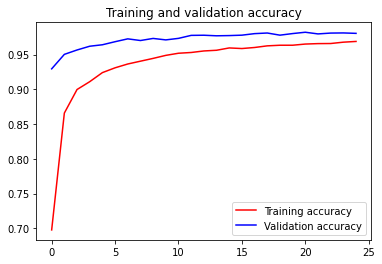

<Figure size 432x288 with 0 Axes>

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

In [ ]:
test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow(test_X,test_y)
test_loss, test_acc = model.evaluate(test_generator, verbose=2)

wandb.log({"test_loss": test_loss, "test_acc": test_acc})

313/313 - 1s - loss: 0.0837 - accuracy: 0.9868 - 989ms/epoch - 3ms/step
